# Demo training for Retinopathy detection

Import libraries

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import pickle
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import scipy

2024-01-29 13:23:37.194568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 13:23:37.194597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 13:23:37.194615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 13:23:37.199510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions definitions, load dataset into array, normalized the datase, build the model with augmentation and training

In [2]:

# Setting up training parameters
batch_size = 32  # Number of samples processed before the model is updated
epoch = 100  # Number of complete passes through the training dataset
initial_learning_rate = 0.01  # Starting learning rate for training
patience = 25  # Number of epochs with no improvement after which training will be stopped

# Path to the dataset
folder_path = '../Database/2Organized'  # Directory with a small sample of photos to test different settings

# Configuring GPU for memory growth to avoid allocating all memory upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def load_data(folder_path):
    """
    Loads data from a specified folder path, applies preprocessing, and creates training and validation generators.
    
    Args:
    - folder_path: Path to the folder containing the dataset.
    
    Returns:
    - A tuple of (train_generator, validation_generator) used for training and validation.
    """
    img_height = 512
    img_width = 512

    # Preprocessing and data augmentation setup
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # Preprocesses the data according to InceptionV3 requirements
        validation_split=0.2  # Splits the data into training (80%) and validation (20%) sets
    )

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(img_height, img_width),  # Resizes images to match model input dimensions
        batch_size=batch_size,
        class_mode='categorical',  # For multi-class classification
        subset='training'  # Specifies this generator is for training data
    )

    # Validation data generator
    validation_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',  # For multi-class classification
        subset='validation'  # Specifies this generator is for validation data
    )

    return train_generator, validation_generator

def build_model(train_generator, validation_generator):
    """
    Builds a transfer learning model using InceptionV3 as the base model with a custom top layer.
    
    Args:
    - train_generator: The training data generator.
    - validation_generator: The validation data generator.
    
    Returns:
    - The compiled model ready for training.
    """
    # Load InceptionV3 as the base model, pre-trained on ImageNet
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Adds a global spatial average pooling layer
    x = Dense(1024, activation='relu')(x)  # Adds a fully connected layer with 1024 units and ReLU activation
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer with softmax activation

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freezing the layers of the base model to not update weights during the first phase of training
    for layer in base_model.layers:
        layer.trainable = False
        
    # Setup for the learning rate schedule for optimization
    decay_steps = int(0.2 * len(train_generator))  # Defines step decay for learning rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = Adam(learning_rate=lr_schedule)

    # Compile the model with loss and metrics settings
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def train_and_save_model(model_name, save_path, history_name):
    """
    Trains the model, saves the best model weights, and stores the training history.
    
    Args:
    - model_name: Name to save the model file as.
    - save_path: Directory path to save the trained model and history.
    - history_name: Name to save the training history file as.
    """
    # Load data using the load_data function
    train_generator, validation_generator = load_data(folder_path)

    # Build model using the build_model function
    model = build_model(train_generator, validation_generator)
    
    # Setup callbacks for early stopping and model checkpointing
    keras_callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience),
        ModelCheckpoint(f"{save_path}/{model_name}", monitor='val_loss', save_best_only=True, verbose=1)
    ]
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epoch,
        shuffle=True,
        callbacks=keras_callbacks  # Callbacks for monitoring
    )

    # Save the training history for later analysis
    with open(f"{save_path}/{history_name}", 'wb') as history_file:
        pickle.dump(history.history, history_file)

2024-01-29 13:23:38.599129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:23:38.602396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:23:38.602521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train the model with different values to compare

In [3]:
# List of batch sizes and learning rates to iterate over
# Using powers of 2 for batch sizes is often more efficient on GPUs.
batch_sizes = [128, 64, 32, 16, 8]
initial_learning_rates = [0.01, 0.001, 0.00001]  # A range of learning rates to test different speeds of convergence

# Iterate over each batch size
for batch in batch_sizes:
    # Then, iterate over each learning rate for the current batch size
    for initial_learning_rate in initial_learning_rates:
        # Setting the current batch size and learning rate for this iteration
        batch_size = batch
        initial_learning_rate = initial_learning_rate
                
        # Defining the save path, model name, and history file name based on the current batch size and learning rate
        save_path = f"../TrainingX/Model_{batch_size}_{initial_learning_rate}"
        model_name = f"Model_{batch_size}_{initial_learning_rate}.h5"
        history_name = f"History_{batch_size}_{initial_learning_rate}.pickle"

        # Check if the model directory already exists to avoid retraining the same configuration
        if not os.path.exists(save_path):
            # If the directory does not exist, train and save the model with the current configuration
            train_and_save_model(model_name, save_path, history_name)
            print(f"Training completed for batch_size={batch_size}, learning_rate={initial_learning_rate}")
        else:
            # If the directory exists, skip training to save time and resources
            print(f"Training skipped for batch_size={batch_size}, learning_rate={initial_learning_rate} as directory already exists")


Found 978 images belonging to 6 classes.
Found 241 images belonging to 6 classes.


2024-01-29 13:23:38.679347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:23:38.679605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 13:23:38.679788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-01-29 13:23:53.938761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2024-01-29 13:23:54.000157: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 13:23:55.767410: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-29 13:23:55.991832: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-29 13:23:55.991851: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate

7/7 [==============================] - ETA: 0s - loss: 20.9673 - accuracy: 0.4612
Epoch 1: val_loss improved from inf to 13.47784, saving model to ../TrainingX/Model_128_0.01/Model_128_0.01.h5


/home/nnds3a/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 57s 7s/step - loss: 20.9673 - accuracy: 0.4612 - val_loss: 13.4778 - val_accuracy: 0.0547
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 7.2311 - accuracy: 0.4435
Epoch 2: val_loss improved from 13.47784 to 1.95007, saving model to ../TrainingX/Model_128_0.01/Model_128_0.01.h5
7/7 [==============================] - 50s 7s/step - loss: 7.2311 - accuracy: 0.4435 - val_loss: 1.9501 - val_accuracy: 0.7656
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.8368 - accuracy: 0.6435
Epoch 3: val_loss improved from 1.95007 to 1.11993, saving model to ../TrainingX/Model_128_0.01/Model_128_0.01.h5
7/7 [==============================] - 49s 8s/step - loss: 1.8368 - accuracy: 0.6435 - val_loss: 1.1199 - val_accuracy: 0.7188
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.6388
Epoch 4: val_loss improved from 1.11993 to 0.99206, saving model to ../TrainingX/Model_128_0.01/Model_128_0.0

Plot the performance of the model with different settings

Plotting completed for all batch sizes and learning rates


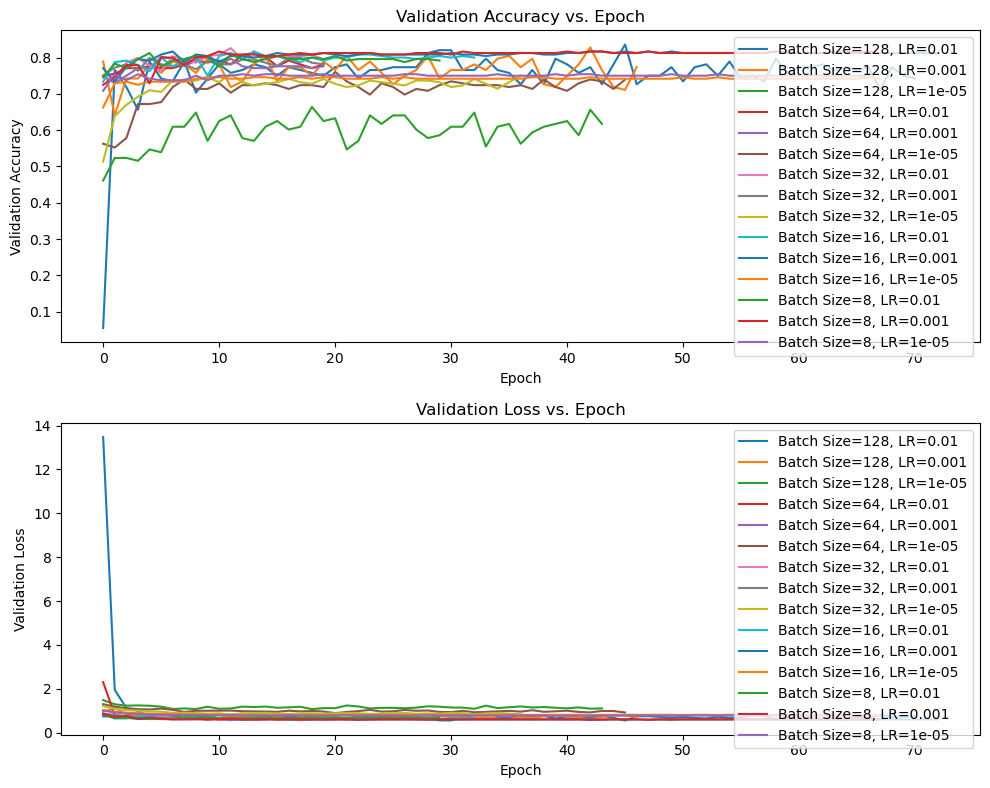

In [5]:
# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for batch in batch_sizes:
    for initial_learning_ratess in initial_learning_rates:
        batch_size = batch
        initial_learning_rate = initial_learning_ratess

        save_path = f"../TrainingX/Model_{batch_size}_{initial_learning_ratess}"
        history_name = f"History_{batch_size}_{initial_learning_ratess}.pickle"

        # Load history from file
        with open(f"{save_path}/{history_name}", 'rb') as file:
            history = pickle.load(file)

        # Plot validation accuracy
        ax1.plot(history['val_accuracy'], label=f'Batch Size={batch_size}, LR={initial_learning_rate}')

        # Plot validation loss
        ax2.plot(history['val_loss'], label=f'Batch Size={batch_size}, LR={initial_learning_rate}')

print("Plotting completed for all batch sizes and learning rates")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Accuracy vs. Epoch')
ax1.legend()

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss vs. Epoch')
ax2.legend()

plt.tight_layout()
plt.show()